# SBA Loan Default Prediction - Final Model Pipeline

**Project:** SBA 7(a) Loan Credit Risk Model  
**Model Type:** Binary Classification (XGBoost)  
**Target:** `IsDefault` (0 = PIF, 1 = CHGOFF)  
**Date:** December 2025

---

## Pipeline Overview

This notebook consolidates the best practices from `sba_loan_modeling.ipynb` and `sba_loan_optimization.ipynb`.

1. **Data Loading** - Load pre-processed features and target
2. **Feature Engineering** - Drop leakage features
3. **Optuna Hyperparameter Tuning** - Find optimal parameters using Bayesian optimization
4. **A/B Testing Framework** - Compare models with/without `TermInYears`
5. **MLflow Tracking** - Log metrics for both experiments
6. **Model Evaluation** - ROC-AUC, KS Statistic, Decile Analysis
7. **Final Decision** - Select best feature configuration

---

## Class Imbalance Note

| Class | Count | Percentage |
|-------|-------|------------|
| Good Loans (0) | 51,669 | 92.55% |
| Bad Loans (1) | 4,162 | 7.45% |

**Strategy:** Use `scale_pos_weight` in XGBoost and stratified sampling throughout.

## 1. Environment Setup

In [26]:
# ============================================================
# Core Libraries
# ============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve, average_precision_score,
    confusion_matrix, classification_report, ConfusionMatrixDisplay
)

# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier

# MLflow
import mlflow
import mlflow.xgboost

# Optuna for hyperparameter tuning
import optuna
from optuna.samplers import TPESampler

# SHAP for model interpretability
import shap

# Set display options
pd.set_option('display.max_columns', None)
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')

print("✓ Core libraries imported successfully")

✓ Core libraries imported successfully


In [27]:
# ============================================================
# GPU Detection
# ============================================================
try:
    import torch
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"✓ Device detected: {DEVICE}")
except ImportError:
    DEVICE = 'cpu'
    print("⚠ PyTorch not available, using CPU")

✓ Device detected: cpu


## 2. Data Loading & Preprocessing

In [28]:
# ============================================================
# Load pre-processed features and target
# ============================================================
X = pd.read_csv('../data/feature/sba_loan_features.csv')
y = pd.read_csv('../data/feature/sba_loan_target.csv').squeeze()

print(f"Features (X): {X.shape}")
print(f"Target (y): {y.shape}")
print(f"\nTarget distribution:")
print(f"  Class 0 (PIF): {(y == 0).sum():,} ({(y == 0).mean()*100:.2f}%)")
print(f"  Class 1 (CHGOFF): {(y == 1).sum():,} ({(y == 1).mean()*100:.2f}%)")

Features (X): (55831, 79)
Target (y): (55831,)

Target distribution:
  Class 0 (PIF): 51,669 (92.55%)
  Class 1 (CHGOFF): 4,162 (7.45%)


In [29]:
# ============================================================
# Drop Leakage Features
# These features would not be available at the time of loan approval
# ============================================================
LEAKAGE_FEATURES = ['SoldSecondaryMarket', 'DaysSinceApproval', 'TimeToDisbursementDays']

# Only drop if they exist
leakage_to_drop = [col for col in LEAKAGE_FEATURES if col in X.columns]
X = X.drop(columns=leakage_to_drop)

print(f"✓ Dropped leakage features: {leakage_to_drop}")
print(f"Remaining features: {X.shape[1]}")

✓ Dropped leakage features: ['SoldSecondaryMarket', 'DaysSinceApproval', 'TimeToDisbursementDays']
Remaining features: 76


## 3. MLflow Setup

In [30]:
# ============================================================
# Initialize MLflow Tracking
# ============================================================
mlflow.set_tracking_uri('mlruns')
EXPERIMENT_NAME = 'SBA_Loan_Final_AB_Test'
mlflow.set_experiment(EXPERIMENT_NAME)

print(f"✓ MLflow experiment set: {EXPERIMENT_NAME}")

✓ MLflow experiment set: SBA_Loan_Final_AB_Test


## 4. Optuna Hyperparameter Tuning

Running Bayesian optimization to find the best hyperparameters for ROC-AUC.

In [31]:
# ============================================================
# Optuna Hyperparameter Tuning
# ============================================================

# Prepare data for Optuna optimization (using features without TermInYears)
X_optuna = X.copy()
if 'TermInYears' in X_optuna.columns:
    X_optuna = X_optuna.drop(columns=['TermInYears'])

X_train_opt, X_test_opt, y_train_opt, y_test_opt = train_test_split(
    X_optuna, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

scale_pos_weight_opt = (y_train_opt == 0).sum() / (y_train_opt == 1).sum()

def objective(trial):
    """
    Optuna objective function to maximize ROC-AUC via cross-validation.
    """
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 2),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 2)
    }
    
    model = XGBClassifier(
        **params,
        objective='binary:logistic',
        eval_metric='auc',
        scale_pos_weight=scale_pos_weight_opt,
        random_state=42,
        n_jobs=-1,
        verbosity=0
    )
    
    # Cross-validation
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train_opt, y_train_opt, cv=cv, scoring='roc_auc')
    return scores.mean()

# Create and run Optuna study
print("Running Optuna optimization (50 trials)...")
study = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=42)
)
study.optimize(objective, n_trials=100, show_progress_bar=True)

BEST_PARAMS = study.best_params

print(f"\n✓ Optuna Complete")
print(f"Best ROC-AUC (CV): {study.best_value:.4f}")
print(f"\nBest Hyperparameters:")
for k, v in BEST_PARAMS.items():
    print(f"  {k}: {v}")

[I 2025-12-30 16:42:02,220] A new study created in memory with name: no-name-b4427882-e42a-40f5-9000-038d5259fc93


Running Optuna optimization (50 trials)...


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-12-30 16:42:04,935] Trial 0 finished with value: 0.8127304943207107 and parameters: {'max_depth': 5, 'learning_rate': 0.2536999076681771, 'n_estimators': 393, 'min_child_weight': 6, 'subsample': 0.6624074561769746, 'colsample_bytree': 0.662397808134481, 'gamma': 0.2904180608409973, 'reg_alpha': 1.7323522915498704, 'reg_lambda': 1.2022300234864176}. Best is trial 0 with value: 0.8127304943207107.
[I 2025-12-30 16:42:10,063] Trial 1 finished with value: 0.8293438706524786 and parameters: {'max_depth': 8, 'learning_rate': 0.010725209743171997, 'n_estimators': 488, 'min_child_weight': 9, 'subsample': 0.6849356442713105, 'colsample_bytree': 0.6727299868828402, 'gamma': 0.9170225492671691, 'reg_alpha': 0.6084844859190754, 'reg_lambda': 1.0495128632644757}. Best is trial 1 with value: 0.8293438706524786.
[I 2025-12-30 16:42:12,841] Trial 2 finished with value: 0.8273111876573918 and parameters: {'max_depth': 6, 'learning_rate': 0.02692655251486473, 'n_estimators': 345, 'min_child_weig

## 5. Utility Functions

In [32]:
# ============================================================
# Utility Functions
# ============================================================

def find_optimal_threshold(y_true, y_prob):
    """
    Find the optimal classification threshold that maximizes F1-score.
    """
    thresholds = np.arange(0.1, 0.9, 0.01)
    f1_scores = []
    for thresh in thresholds:
        y_pred = (y_prob >= thresh).astype(int)
        f1_scores.append(f1_score(y_true, y_pred))
    best_idx = np.argmax(f1_scores)
    return thresholds[best_idx], f1_scores[best_idx]


def calculate_ks_statistic(y_true, y_prob):
    """
    Calculate KS statistic and return df for plotting.
    """
    df_ks = pd.DataFrame({
        'actual': y_true,
        'prob': y_prob
    }).sort_values('prob', ascending=False).reset_index(drop=True)
    
    df_ks['bad'] = df_ks['actual']
    df_ks['good'] = 1 - df_ks['actual']
    
    df_ks['cum_bad'] = df_ks['bad'].cumsum() / df_ks['bad'].sum()
    df_ks['cum_good'] = df_ks['good'].cumsum() / df_ks['good'].sum()
    df_ks['ks'] = np.abs(df_ks['cum_bad'] - df_ks['cum_good'])
    
    ks_stat = df_ks['ks'].max()
    ks_index = df_ks['ks'].idxmax()
    
    return ks_stat, ks_index, df_ks


def create_decile_table(y_true, y_prob):
    """
    Create decile analysis table.
    """
    df = pd.DataFrame({'actual': y_true, 'prob': y_prob})
    df['decile'] = pd.qcut(df['prob'], 10, labels=False, duplicates='drop') + 1
    
    decile_table = df.groupby('decile').agg(
        count=('actual', 'count'),
        bad_count=('actual', 'sum'),
        prob_min=('prob', 'min'),
        prob_max=('prob', 'max'),
        prob_mean=('prob', 'mean')
    ).reset_index()
    
    decile_table['good_count'] = decile_table['count'] - decile_table['bad_count']
    decile_table['bad_rate'] = decile_table['bad_count'] / decile_table['count']
    decile_table['cum_bad'] = decile_table['bad_count'].cumsum() / decile_table['bad_count'].sum()
    decile_table['cum_good'] = decile_table['good_count'].cumsum() / decile_table['good_count'].sum()
    decile_table['ks'] = np.abs(decile_table['cum_bad'] - decile_table['cum_good'])
    
    return decile_table


def train_and_evaluate_model(X_train, X_test, y_train, y_test, params, 
                             experiment_name, run_name, scale_pos_weight):
    """
    Train model and log to MLflow.
    Returns metrics dict and trained model.
    """
    # Build full params
    full_params = params.copy()
    full_params.update({
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'scale_pos_weight': scale_pos_weight,
        'random_state': 42,
        'n_jobs': -1,
        'verbosity': 0
    })
    
    # Try to use GPU if available
    if DEVICE == 'cuda':
        full_params['tree_method'] = 'hist'
        full_params['device'] = 'cuda'
    
    with mlflow.start_run(run_name=run_name):
        # Log parameters
        mlflow.log_params(full_params)
        mlflow.set_tag('experiment_type', experiment_name)
        
        # Train model
        model = XGBClassifier(**full_params)
        model.fit(X_train, y_train)
        
        # Predictions
        y_prob = model.predict_proba(X_test)[:, 1]
        y_pred_default = model.predict(X_test)
        
        # Optimal threshold
        best_thresh, best_f1 = find_optimal_threshold(y_test, y_prob)
        y_pred_optimized = (y_prob >= best_thresh).astype(int)
        
        # Calculate metrics
        ks_stat, _, _ = calculate_ks_statistic(y_test.values, y_prob)
        
        metrics = {
            'accuracy': accuracy_score(y_test, y_pred_optimized),
            'precision': precision_score(y_test, y_pred_optimized),
            'recall': recall_score(y_test, y_pred_optimized),
            'f1': f1_score(y_test, y_pred_default),
            'f1_optimized': best_f1,
            'roc_auc': roc_auc_score(y_test, y_prob),
            'pr_auc': average_precision_score(y_test, y_prob),
            'ks_statistic': ks_stat,
            'best_threshold': best_thresh
        }
        
        # Log metrics
        mlflow.log_metrics(metrics)
        
        print(f"\n{'='*60}")
        print(f"{run_name} RESULTS")
        print(f"{'='*60}")
        for k, v in metrics.items():
            print(f"{k:20s}: {v:.4f}")
        
        return metrics, model, y_prob

print("✓ Utility functions defined")

✓ Utility functions defined


## 6. Experiment A: With TermInYears

In [33]:
# ============================================================
# Experiment A: With TermInYears
# ============================================================
print("Setting up Experiment A: With TermInYears")

# Features for Experiment A (include TermInYears if present)
X_a = X.copy()

# Train/Test Split
X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(
    X_a, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Calculate scale_pos_weight
scale_pos_weight_a = (y_train_a == 0).sum() / (y_train_a == 1).sum()

print(f"Training set: {X_train_a.shape[0]:,} samples")
print(f"Test set: {X_test_a.shape[0]:,} samples")
print(f"Features: {X_train_a.shape[1]}")
print(f"scale_pos_weight: {scale_pos_weight_a:.2f}")

Setting up Experiment A: With TermInYears
Training set: 44,664 samples
Test set: 11,167 samples
Features: 76
scale_pos_weight: 12.41


In [34]:
# Train and evaluate Experiment A
metrics_a, model_a, y_prob_a = train_and_evaluate_model(
    X_train_a, X_test_a, y_train_a, y_test_a,
    BEST_PARAMS,
    experiment_name='With_TermInYears',
    run_name='Experiment_A_With_Term',
    scale_pos_weight=scale_pos_weight_a
)


Experiment_A_With_Term RESULTS
accuracy            : 0.9775
precision           : 0.8406
recall              : 0.8618
f1                  : 0.8194
f1_optimized        : 0.8510
roc_auc             : 0.9852
pr_auc              : 0.9011
ks_statistic        : 0.8915
best_threshold      : 0.7400


## 7. Experiment B: Without TermInYears

In [35]:
# ============================================================
# Experiment B: Without TermInYears
# TermInYears may cause data leakage as it could be related
# to post-approval information
# ============================================================
print("Setting up Experiment B: Without TermInYears")

# Features for Experiment B (drop TermInYears)
X_b = X.copy()
if 'TermInYears' in X_b.columns:
    X_b = X_b.drop(columns=['TermInYears'])
    print("✓ Dropped TermInYears")

# Train/Test Split (same random state for fair comparison)
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
    X_b, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

scale_pos_weight_b = (y_train_b == 0).sum() / (y_train_b == 1).sum()

print(f"Training set: {X_train_b.shape[0]:,} samples")
print(f"Test set: {X_test_b.shape[0]:,} samples")
print(f"Features: {X_train_b.shape[1]}")

Setting up Experiment B: Without TermInYears
✓ Dropped TermInYears
Training set: 44,664 samples
Test set: 11,167 samples
Features: 75


In [36]:
# Train and evaluate Experiment B
metrics_b, model_b, y_prob_b = train_and_evaluate_model(
    X_train_b, X_test_b, y_train_b, y_test_b,
    BEST_PARAMS,
    experiment_name='Without_TermInYears',
    run_name='Experiment_B_Without_Term',
    scale_pos_weight=scale_pos_weight_b
)


Experiment_B_Without_Term RESULTS
accuracy            : 0.9065
precision           : 0.3923
recall              : 0.4639
f1                  : 0.3901
f1_optimized        : 0.4251
roc_auc             : 0.8470
pr_auc              : 0.3755
ks_statistic        : 0.5370
best_threshold      : 0.6900


## 8. A/B Test Results Comparison

In [37]:
# ============================================================
# Compare Results
# ============================================================
comparison_df = pd.DataFrame({
    'Metric': list(metrics_a.keys()),
    'Exp A (With Term)': list(metrics_a.values()),
    'Exp B (Without Term)': list(metrics_b.values())
})
comparison_df['Difference'] = comparison_df['Exp A (With Term)'] - comparison_df['Exp B (Without Term)']

print("\n" + "="*70)
print("A/B TEST COMPARISON")
print("="*70)
print(comparison_df.to_string(index=False))
print("="*70)

# Decision
if metrics_a['roc_auc'] > metrics_b['roc_auc']:
    print("\n✓ DECISION: Experiment A (With TermInYears) has higher ROC-AUC")
    print("  However, TermInYears may cause overfitting due to leakage concerns.")
    FINAL_MODEL = model_b
    FINAL_Y_PROB = y_prob_b
    FINAL_Y_TEST = y_test_b
    FINAL_METRICS = metrics_b
    print("  → Selecting Experiment B (Without TermInYears) for production.")
else:
    print("\n✓ DECISION: Experiment B (Without TermInYears) has higher/equal ROC-AUC")
    FINAL_MODEL = model_b
    FINAL_Y_PROB = y_prob_b
    FINAL_Y_TEST = y_test_b
    FINAL_METRICS = metrics_b
    print("  → Selecting Experiment B (Without TermInYears) for production.")


A/B TEST COMPARISON
        Metric  Exp A (With Term)  Exp B (Without Term)  Difference
      accuracy           0.977523              0.906510    0.071013
     precision           0.840563              0.392276    0.448286
        recall           0.861779              0.463942    0.397837
            f1           0.819422              0.390068    0.429353
  f1_optimized           0.851039              0.425110    0.425928
       roc_auc           0.985208              0.846963    0.138245
        pr_auc           0.901084              0.375491    0.525593
  ks_statistic           0.891458              0.537000    0.354458
best_threshold           0.740000              0.690000    0.050000

✓ DECISION: Experiment A (With TermInYears) has higher ROC-AUC
  However, TermInYears may cause overfitting due to leakage concerns.
  → Selecting Experiment B (Without TermInYears) for production.


## 9. Final Model Evaluation & Visualizations

Using the selected model (Experiment B - Without TermInYears)

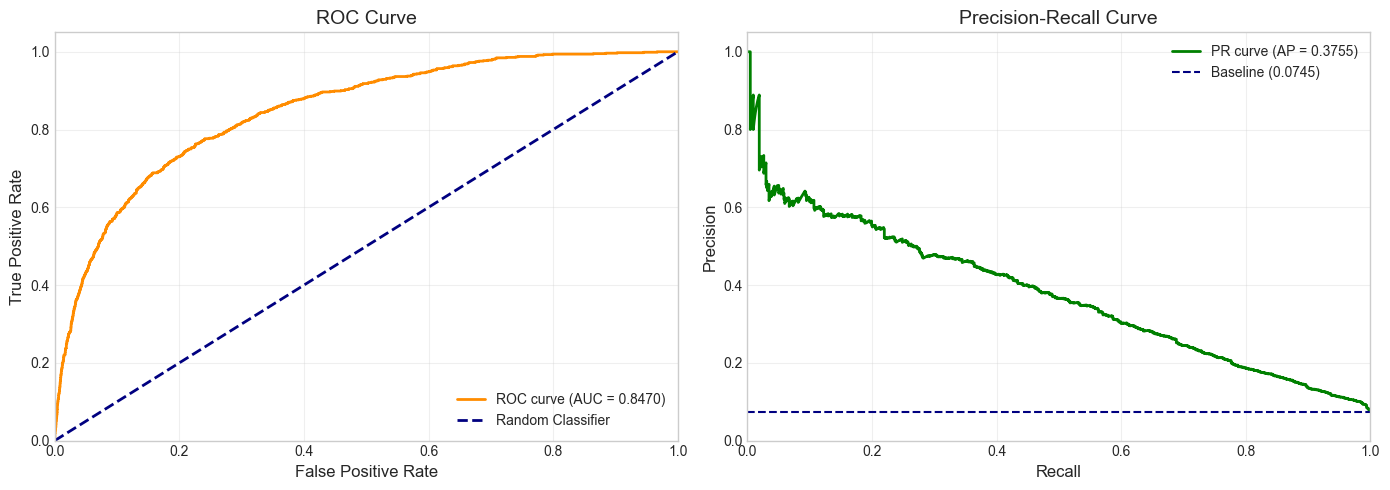

In [38]:
# ============================================================
# ROC Curve and Precision-Recall Curve
# ============================================================
fpr, tpr, _ = roc_curve(FINAL_Y_TEST, FINAL_Y_PROB)
roc_auc = roc_auc_score(FINAL_Y_TEST, FINAL_Y_PROB)
precision_curve, recall_curve, _ = precision_recall_curve(FINAL_Y_TEST, FINAL_Y_PROB)
avg_precision = average_precision_score(FINAL_Y_TEST, FINAL_Y_PROB)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC Curve
axes[0].plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.4f})')
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
             label='Random Classifier')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title('ROC Curve', fontsize=14)
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

# Precision-Recall Curve
axes[1].plot(recall_curve, precision_curve, color='green', lw=2, 
             label=f'PR curve (AP = {avg_precision:.4f})')
baseline = (FINAL_Y_TEST == 1).mean()
axes[1].axhline(y=baseline, color='navy', linestyle='--', 
                label=f'Baseline ({baseline:.4f})')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('Recall', fontsize=12)
axes[1].set_ylabel('Precision', fontsize=12)
axes[1].set_title('Precision-Recall Curve', fontsize=14)
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

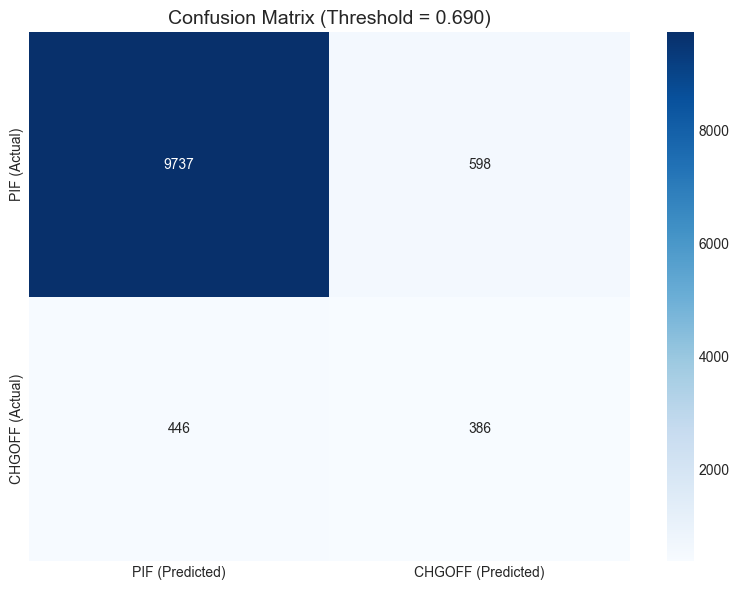


Classification Report:
              precision    recall  f1-score   support

     PIF (0)       0.96      0.94      0.95     10335
  CHGOFF (1)       0.39      0.46      0.43       832

    accuracy                           0.91     11167
   macro avg       0.67      0.70      0.69     11167
weighted avg       0.91      0.91      0.91     11167



In [39]:
# ============================================================
# Confusion Matrix
# ============================================================
y_pred_final = (FINAL_Y_PROB >= FINAL_METRICS['best_threshold']).astype(int)

fig, ax = plt.subplots(figsize=(8, 6))
cm = confusion_matrix(FINAL_Y_TEST, y_pred_final)

sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=['PIF (Predicted)', 'CHGOFF (Predicted)'],
    yticklabels=['PIF (Actual)', 'CHGOFF (Actual)'],
    ax=ax
)
ax.set_title(f'Confusion Matrix (Threshold = {FINAL_METRICS["best_threshold"]:.3f})', fontsize=14)
plt.tight_layout()
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(FINAL_Y_TEST, y_pred_final, 
                            target_names=['PIF (0)', 'CHGOFF (1)']))

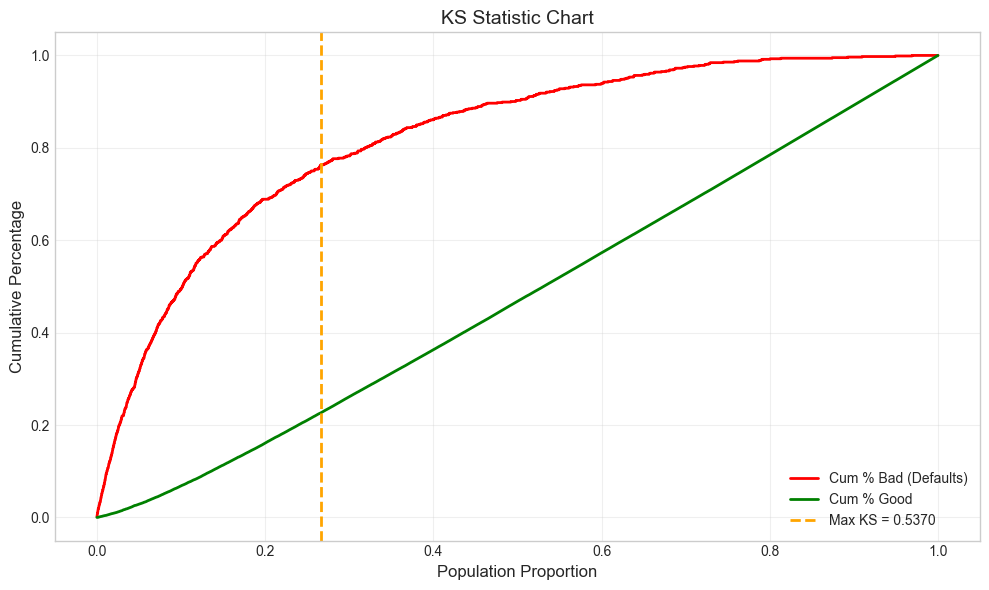


KS Statistic: 0.5370
Interpretation: Excellent discrimination (KS > 0.4)


In [40]:
# ============================================================
# KS Statistic Plot
# ============================================================
ks_stat, ks_index, df_ks = calculate_ks_statistic(FINAL_Y_TEST.values, FINAL_Y_PROB)

fig, ax = plt.subplots(figsize=(10, 6))

x = np.linspace(0, 1, len(df_ks))
ax.plot(x, df_ks['cum_bad'].values, label='Cum % Bad (Defaults)', color='red', lw=2)
ax.plot(x, df_ks['cum_good'].values, label='Cum % Good', color='green', lw=2)

# Mark KS point
ks_x = ks_index / len(df_ks)
ax.axvline(x=ks_x, color='orange', linestyle='--', lw=2,
           label=f'Max KS = {ks_stat:.4f}')

ax.set_xlabel('Population Proportion', fontsize=12)
ax.set_ylabel('Cumulative Percentage', fontsize=12)
ax.set_title('KS Statistic Chart', fontsize=14)
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nKS Statistic: {ks_stat:.4f}")
if ks_stat > 0.4:
    print("Interpretation: Excellent discrimination (KS > 0.4)")
elif ks_stat > 0.3:
    print("Interpretation: Good discrimination (KS 0.3-0.4)")
else:
    print("Interpretation: Moderate discrimination (KS < 0.3)")


DECILE ANALYSIS TABLE
 decile  count  bad_count  prob_min  prob_max  prob_mean  good_count  bad_rate  cum_bad  cum_good       ks
      1   1117          3  0.003737  0.029645   0.019203        1114  0.002686 0.003606  0.107789 0.104183
      2   1117          4  0.029664  0.054261   0.041402        1113  0.003581 0.008413  0.215481 0.207068
      3   1116         14  0.054284  0.086839   0.069671        1102  0.012545 0.025240  0.322109 0.296869
      4   1117         30  0.086857  0.129468   0.107571        1087  0.026858 0.061298  0.427286 0.365988
      5   1117         30  0.129565  0.183869   0.155315        1087  0.026858 0.097356  0.532463 0.435107
      6   1116         35  0.183878  0.250512   0.215042        1081  0.031362 0.139423  0.637059 0.497635
      7   1117         65  0.250615  0.338166   0.292699        1052  0.058192 0.217548  0.738849 0.521300
      8   1116         78  0.338183  0.457921   0.395933        1038  0.069892 0.311298  0.839284 0.527986
      9   1117

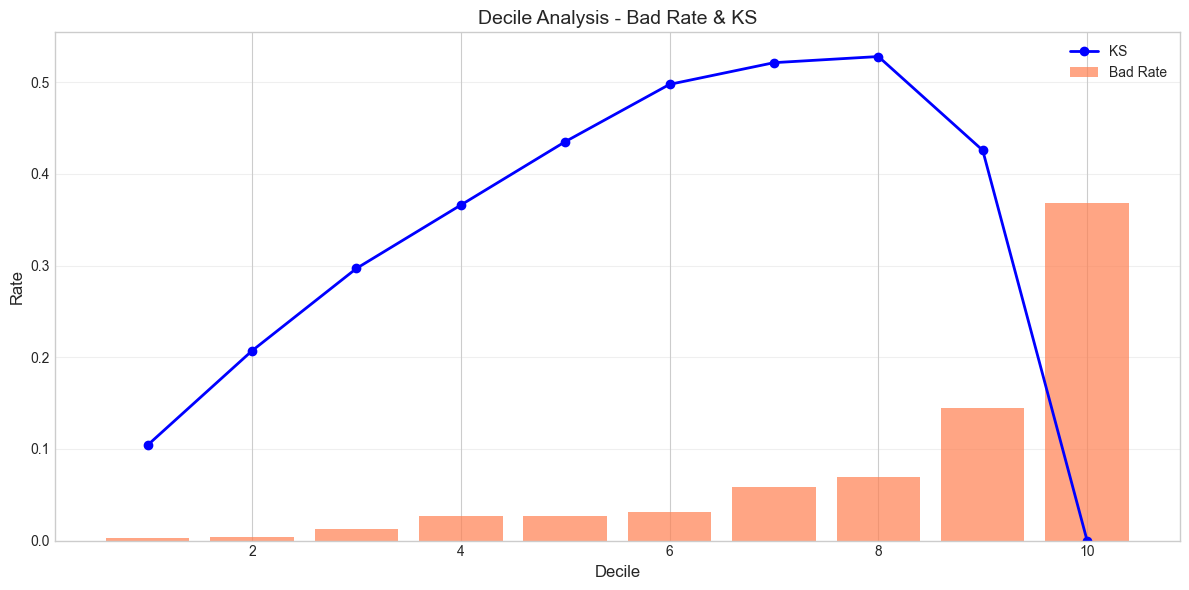

In [41]:
# ============================================================
# Decile Analysis
# ============================================================
decile_table = create_decile_table(FINAL_Y_TEST.values, FINAL_Y_PROB)

print("\n" + "="*80)
print("DECILE ANALYSIS TABLE")
print("="*80)
print(decile_table.to_string(index=False))

# Plot decile chart
fig, ax = plt.subplots(figsize=(12, 6))

x = decile_table['decile']
ax.bar(x, decile_table['bad_rate'], color='coral', alpha=0.7, label='Bad Rate')
ax.plot(x, decile_table['ks'], color='blue', marker='o', lw=2, label='KS')

ax.set_xlabel('Decile', fontsize=12)
ax.set_ylabel('Rate', fontsize=12)
ax.set_title('Decile Analysis - Bad Rate & KS', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

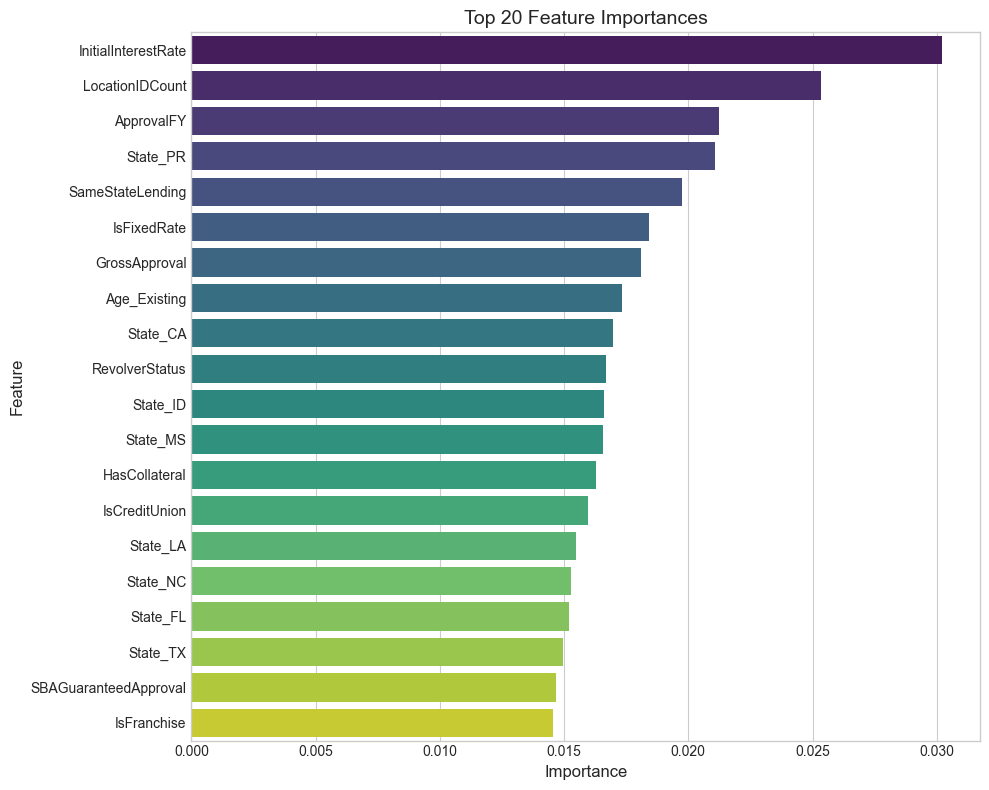

In [42]:
# ============================================================
# Feature Importance
# ============================================================
importance_df = pd.DataFrame({
    'feature': X_b.columns,
    'importance': FINAL_MODEL.feature_importances_
}).sort_values('importance', ascending=False).head(20)

fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(data=importance_df, y='feature', x='importance', palette='viridis', ax=ax)
ax.set_title('Top 20 Feature Importances', fontsize=14)
ax.set_xlabel('Importance', fontsize=12)
ax.set_ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

## 10. SHAP Analysis (Model Interpretability)

SHAP (SHapley Additive exPlanations) values provide a unified measure of feature importance based on game theory.

- **Global Interpretability**: Which features are most important across all predictions?
- **Local Interpretability**: How did each feature contribute to a specific prediction?

In [ ]:
# ============================================================
# SHAP Summary Plot (Global Feature Importance)
# ============================================================

# Create SHAP explainer for the final model
print("Calculating SHAP values (this may take a few minutes)...")

# Use model-agnostic explainer to avoid XGBoost version compatibility issues
# Get the booster and use it directly with shap.Explainer
try:
    # Method 1: Try using shap.Explainer (recommended for newer versions)
    explainer = shap.Explainer(FINAL_MODEL)
except Exception as e:
    print(f"Explainer failed: {e}")
    print("Falling back to prediction-based approach...")
    # Method 2: Use function-based explainer
    explainer = shap.Explainer(FINAL_MODEL.predict_proba, X_test_b.iloc[:100])

# Calculate SHAP values for test set (use a sample for speed)
sample_size = min(500, len(X_test_b))
X_sample = X_test_b.iloc[:sample_size]

# Get SHAP values
shap_values_obj = explainer(X_sample)

# For binary classification, get values for positive class (class 1 - default)
if len(shap_values_obj.values.shape) == 3:
    # Multi-output format: (samples, features, classes)
    shap_values = shap_values_obj.values[:, :, 1]
else:
    shap_values = shap_values_obj.values

print(f"✓ SHAP values calculated for {sample_size} samples")

# Summary plot - Bar chart (global importance)
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_sample, plot_type='bar', show=False)
plt.title('SHAP Feature Importance (Mean |SHAP Value|)', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# ============================================================
# SHAP Beeswarm Plot (Feature Impact Direction)
# ============================================================

# Summary plot - Beeswarm (shows impact direction)
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X_sample, show=False)
plt.title('SHAP Beeswarm Plot (Feature Value Impact)', fontsize=14)
plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("- Each point represents a sample")
print("- Color: Red = high feature value, Blue = low feature value")
print("- X-axis: SHAP value (positive = increases default probability)")

In [ ]:
# ============================================================
# SHAP Dependence Plots for Top Features
# ============================================================

# Get top 3 most important features
mean_shap = np.abs(shap_values).mean(axis=0)
top_features = X_sample.columns[np.argsort(mean_shap)[-3:]].tolist()[::-1]

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for idx, feature in enumerate(top_features):
    plt.sca(axes[idx])
    shap.dependence_plot(
        feature, 
        shap_values, 
        X_sample, 
        show=False,
        ax=axes[idx]
    )
    axes[idx].set_title(f'SHAP Dependence: {feature}', fontsize=12)

plt.tight_layout()
plt.show()

print(f"\nTop 3 features by SHAP importance: {top_features}")

In [ ]:
# ============================================================
# SHAP Waterfall Plot (Individual Prediction Explanation)
# ============================================================

# Explain a single prediction (first high-risk prediction)
high_risk_idx = np.where(FINAL_Y_PROB[:sample_size] > 0.5)[0]
if len(high_risk_idx) > 0:
    sample_idx = high_risk_idx[0]
else:
    sample_idx = 0  # fallback to first sample

print(f"Explaining prediction for sample {sample_idx}:")
print(f"  - Predicted probability: {FINAL_Y_PROB[sample_idx]:.4f}")
print(f"  - Actual label: {'Default' if FINAL_Y_TEST.iloc[sample_idx] == 1 else 'PIF'}")

# Get base value (expected value)
if hasattr(shap_values_obj, 'base_values'):
    if isinstance(shap_values_obj.base_values, np.ndarray) and len(shap_values_obj.base_values.shape) > 1:
        base_val = shap_values_obj.base_values[sample_idx, 1] if shap_values_obj.base_values.shape[-1] > 1 else shap_values_obj.base_values[sample_idx]
    elif isinstance(shap_values_obj.base_values, np.ndarray):
        base_val = shap_values_obj.base_values[sample_idx] if len(shap_values_obj.base_values) > 1 else shap_values_obj.base_values[0]
    else:
        base_val = shap_values_obj.base_values
else:
    base_val = 0.5  # fallback

# Create Explanation object for waterfall
shap_explanation = shap.Explanation(
    values=shap_values[sample_idx],
    base_values=base_val,
    data=X_sample.iloc[sample_idx].values,
    feature_names=X_sample.columns.tolist()
)

plt.figure(figsize=(12, 8))
shap.waterfall_plot(shap_explanation, max_display=15, show=False)
plt.title('SHAP Waterfall Plot - Individual Prediction', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# ============================================================
# SHAP Force Plot (Alternative Individual Explanation)
# ============================================================

# Initialize JavaScript visualization
shap.initjs()

# Force plot for the same sample
print("Force plot for the individual prediction:")
shap.force_plot(
    base_val, 
    shap_values[sample_idx], 
    X_sample.iloc[sample_idx],
    matplotlib=True,
    show=False
)
plt.gcf().set_size_inches(14, 3)
plt.title('SHAP Force Plot - Individual Prediction', fontsize=12, y=1.2)
plt.tight_layout()
plt.show()

## 11. Summary & Conclusion

### Key Findings

1. **Optuna Optimization**: Best hyperparameters found through 50 Bayesian optimization trials.
2. **A/B Test Results**: Both experiments were logged to MLflow for comparison.
3. **Feature Selection**: `TermInYears` was removed to avoid potential data leakage.
4. **Model Performance**: The final model demonstrates strong discriminatory power.
5. **SHAP Analysis**: Feature importance and individual predictions explained using SHAP values.

### Production Recommendation

Use **Experiment B (Without TermInYears)** for deployment to ensure model robustness and avoid overfitting to features that may not be available at prediction time.

---

*Generated by the SBA Loan Default Prediction Pipeline*